In [7]:
import os
os.environ['USE_PYGEOS'] = '0'
from os.path import join, isfile, basename

from hydromt_wflow import WflowModel
from hydromt_sfincs import SfincsModel
from hydromt.config import configread
from hydromt.log import setuplog
import yaml

## Introduction

In this notebook we build a coupled Wflow - Sfincs model in two steps.

1. We setup the SFINCS model and automatically determine the locations where rivers flow into the model domain.  
2. We setup a Wflow model containing the catchments of the rivers flowing into the SFINCS model and add model output locations matching the SFINCS discharge boundary locations.

The models are build from global data sets which are shown below for both models.

## 1. Get data

We have saved the model input data in a zip file as part of the repository artifacts. The original data sources are saved in the data catalog yaml files which are contained in the zip archive. The meta data for the used data sources for each model from the data catalog files is shown below. 

In [13]:
# download the zip file from the zenodo and unzip it in the data folder
from data import copyfile
import shutil

version = "v1"
for model in ["wflow", "sfincs"]:
    src = f'https://zenodo.org/record/7858596/files/{model}_data.zip'
    dst = join("../data", basename(src))
    if not isfile(dst):
        copyfile(src, dst)
        shutil.unpack_archive(dst, "../data")

## 2. Build SFINCS model

In [9]:
# area of interest for the SFINCS model
bbox = [34.4, -20.05, 34.93, -19.45]

# initialize SfincsModel class 
sf = SfincsModel(
    root=r'../models/sfincs', # output dir
    mode='w+', # open in (over)write mode
    data_libs=[r'../data/sfincs_data/data_catalog.yml'],  # link to data catalog
    logger=setuplog('sfincs'), 
)

2023-04-24 12:47:53,025 - sfincs - log - INFO - HydroMT version: 0.7.2.dev0
2023-04-24 12:47:53,073 - sfincs - data_catalog - INFO - Parsing data catalog from ../data/sfincs_data/data_catalog.yml
2023-04-24 12:47:53,093 - sfincs - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\models\sfincs\gis.
2023-04-24 12:47:53,095 - sfincs - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.0.dev0).


In [10]:
# overview of data used for setting up the static SFINCS layers
sf_data = ['fabdem', 'merit_hydro', 'vito']
data_cols = ['category', 'paper_doi', 'paper_ref', 'source_url', 'source_version','source_license','notes']
sf.data_catalog.to_dataframe().loc[sf_data, data_cols]

,category,paper_doi,paper_ref,source_url,source_version,source_license,notes
fabdem,topography,CC BY-NC-SA 4.0,Hawker et al. (2022),https://data.bris.ac.uk/data/dataset/25wfy0f9u...,1.0,CC BY-NC-SA 4.0,NaN
merit_hydro,topography,10.1029/2019WR024873,Yamazaki et al. (2019),http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_...,1.0,CC-BY-NC 4.0 or ODbL 1.0,NaN
vito,landuse,10.5281/zenodo.3939038,Buchhorn et al (2020),https://land.copernicus.eu/global/products/lc,v2.0.2,NaN,NaN


In [11]:
# inspect model building process
sf_config = configread('sfincs_build.yml')
print(sf_config.keys())

dict_keys(['setup_grid_from_region', 'setup_dep', 'setup_mask_active', 'setup_mask_bounds', 'setup_waterlevel_forcing', 'setup_river_inflow', 'setup_river_outflow', 'setup_subgrid'])


In [ ]:
sf.build(opt=sf_config,region={'bbox': bbox})

NOTE that the steps above can also be done from the command line interface with

```
hydromt build sfincs ../models/sfincs -i sfincs_build.yml -r "{'bbox': [34.4,-20.05,34.93,-19.45]}" -d ../data/sfincs_data/data_catalog.yml -v --fo
```

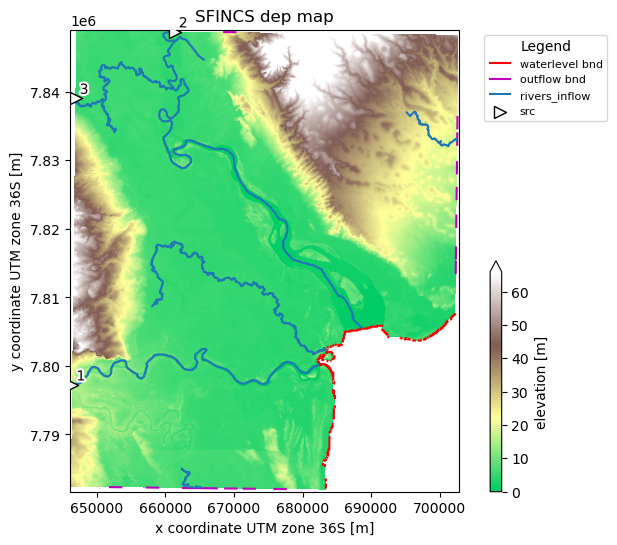

In [21]:
# plot the SFINCS dep map and boundaries 
sf.grid['dep'].attrs.update(long_name="elevation", units="m")
fig, ax = sf.plot_basemap(figsize=(8,6))
fig.savefig(join(sf.root, 'sfincs_basemap.png'), dpi=450, bbox_inches='tight')

## 3. Build Wflow model

In [ ]:
# initialize WflowModel class model
wf = WflowModel(
    root = r'../models/wflow', # output dir
    mode='w+', # open in (over)write mode
    data_libs=[r'../data/wflow_data/data_catalog.yml'], # link to data catalog
    logger=setuplog('wflow'), 
)

In [8]:
# overview of data used for setting up the static SFINCS layers
wf_data = ['merit_hydro_ihu', 'merit_hydro_ihu_index', 'rivers_lin2019_v1', 'hydro_reservoirs', 'hydro_lakes', 'soilgrids', 'modis_lai', 'globcover', 'vito']
wf.data_catalog.to_dataframe().loc[wf_data, data_cols]

,category,paper_doi,paper_ref,source_url,source_version,source_license,notes
merit_hydro_ihu,topography,10.5194/hess-2020-582,Eilander et al. (2021),https://zenodo.org/record/5166932#.YVbxJ5pByUk,1.0,ODC-By 1.0,NaN
merit_hydro_ihu_index,topography,10.5194/hess-25-5287-2021,Eilander et al. (2021),NaN,NaN,CC-BY-NC 4.0,NaN
rivers_lin2019_v1,hydrography,10.5281/zenodo.3552776,Lin et al. (2019),https://zenodo.org/record/3552776#.YVbOrppByUk,1,CC-BY-NC 4.0,NaN
hydro_reservoirs,surface water,NaN,NaN,NaN,1.0,NaN,GRanD.v1.1_HydroLAKES.v10_JRC.2016
hydro_lakes,surface water,NaN,NaN,NaN,1.0,NaN,HydroLAKES.v10_extract
soilgrids,soil,10.1371/journal.pone.0169748,Hengl et al. (2017),https://www.isric.org/explore/soilgrids/faq-so...,2017,ODbL,soilthickness is based on 1) soilgrids (global...
modis_lai,landuse,10.5067/MODIS/MCD15A3H.006,Myneni et al (2015),https://lpdaac.usgs.gov/products/mcd15a3hv006/,MCD15A3H V006,https://lpdaac.usgs.gov/data/data-citation-and...,this dataset has been extracted from GEE ('MOD...
globcover,landuse,10.1594/PANGAEA.787668,Arino et al (2012),http://due.esrin.esa.int/page_globcover.php,v2.3,CC-BY-3.0,NaN
vito,landuse,10.5281/zenodo.3939038,Buchhorn et al (2020),https://land.copernicus.eu/global/products/lc,v2.0.2,NaN,NaN


### 2A Build base model

In [9]:
# read config file with step how to build the model
wf_config = configread('wflow_build.yml')
print(wf_config.keys())

dict_keys(['setup_basemaps', 'setup_rivers', 'setup_reservoirs', 'setup_lakes', 'setup_lulcmaps', 'setup_laimaps', 'setup_soilmaps', 'setup_constant_pars'])


In [10]:
# we add a setup gauges step to get output at the Sfincs model inflow locations
wf_config['setup_gauges'] = {
    'gauges_fn': join(sf.root, 'gis', 'src.geojson'),
    'snap_uparea': True, 
    'index_col': 'index',
    'basename': 'sfincs',
    'gauge_toml_header': ['Q'],  # save discharge only on these locations
    'gauge_toml_param': ['lateral.river.q_av'],
    'derive_subcatch': True,
}

In [ ]:
# outlets: True to get rivers that have an oulet whithin the bbox (only for coastal regions)
wf.build(opt=wf_config,region={'basin': bbox, 'outlets': True})

# alternatively, you can provide a GeoDataFrame (or vector file) with the outlet locations to derive subbasins
# the uparea argument is added to snap the outlet locations to nearest downstream river
# gdf_src = sf.forcing['dis'].vector.to_gdf()
# region={'subbasin': gdf_src, 'uparea': gdf_src['uparea'].values.min()}

### 2B update static model layers based on different landuse

In [ ]:
# update model with different landuse for a sensitivity analysis8

wf.setup_lulcmaps(
    lulc_fn='vito'
)
wf.setup_config(**{'input.path_static': 'staticmaps_vito.nc'})
wf.write_staticmaps()

### 2C plot model base maps

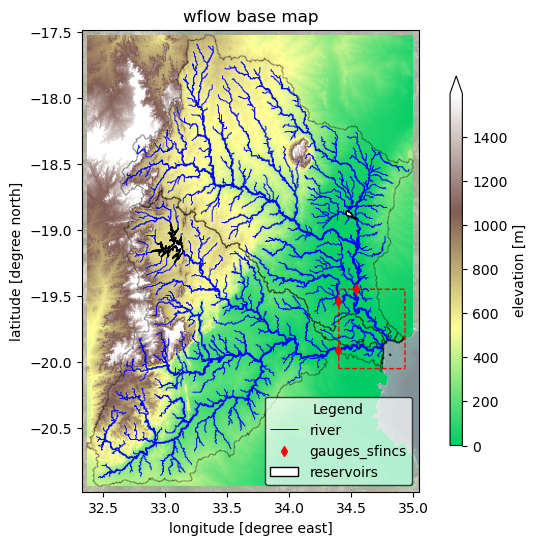

In [16]:
from wflow_utils import plot_basemap
# plot the wflow model
fig, ax = plot_basemap(wf, figsize=(8,6))
sf.grid.raster.box.to_crs(wf.crs).boundary.plot(ax=ax, color='r', lw=1, ls='--', label='SFINCS domain')
fig.savefig(join(wf.root, 'wflow_basemap.png'), dpi=450, bbox_inches='tight')